In [1]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import fastai
from fastai.vision.all import *

from PIL import Image, ImageOps


In [2]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [15]:
mnist_pwd = "data"
batch_size= 16

transform = transforms.Compose([transforms.RandomRotation(30,expand=True), transforms.Resize([28,28]), transforms.ToTensor()])
trainset = MNIST(mnist_pwd, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, device= device)

testset = MNIST(mnist_pwd, train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size * 2, shuffle=False, num_workers=4,device= device)

In [16]:
data = DataLoaders(trainloader, testloader)

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #1 x 28 x 28
        self.conv1 = torch.nn.Conv2d(in_channels= 1, out_channels= 32, kernel_size= (3, 3),  padding = 1)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.pool1 = torch.nn.MaxPool2d(kernel_size= (2, 2)) #out 16 x (14 x 14)

        self.conv2 = torch.nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= (3, 3),  padding = 1)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.pool2 = torch.nn.MaxPool2d(kernel_size= (2, 2)) #out 32 x (7 x 7)

        self.conv3 = torch.nn.Conv2d(in_channels= 64, out_channels= 16, kernel_size= (2, 2))
        self.bn3 = torch.nn.BatchNorm2d(16)
        self.pool3 = torch.nn.MaxPool2d(kernel_size= (2, 2)) #out 16 x (3 x 3)

        self.conv4 = torch.nn.Conv2d(in_channels= 16, out_channels= 10, kernel_size= (3, 3))
        #out 10 x (1 x 1)

        self.Flatten = torch.nn.Flatten()
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        
        x = self.Flatten(x)

        return x

In [18]:
model = Net()
model.to(device)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 16, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 10, kernel_size=(3, 3), stride=(1, 1))
  (Flatten): Flatten(start_dim=1, end_dim=-1)
)

In [20]:
from torchinfo import summary
input_size_with_batch = (1, 1, 28, 28)

_ = summary(model, input_size_with_batch)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Conv2d: 1-7                            [1, 16, 6, 6]             4,112
├─BatchNorm2d: 1-8                       [1, 16, 6, 6]             32
├─MaxPool2d: 1-9                         [1, 16, 3, 3]             --
├─Conv2d: 1-10                           [1, 10, 1, 1]             1,450
├─Flatten: 1-11                          [1, 10]                   --
Total params: 24,602
Trainable params: 24,602
Non-trainable params: 0
Total mult-adds (M): 3.99
Input size (MB): 0.00
Forward/backward pass siz

In [21]:
data.to(device)

In [22]:
learn = Learner(data, model, loss_func=torch.nn.CrossEntropyLoss())


SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=9.12010818865383e-07)

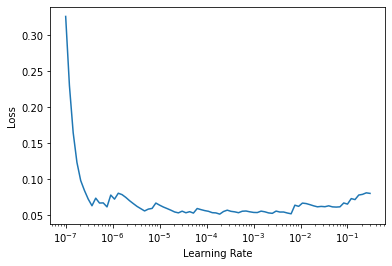

In [25]:
learn.lr_find(suggestions=True)

In [24]:
learn.fit_one_cycle(6, 0.07585775852203369)

epoch,train_loss,valid_loss,time
0,0.320257,0.269068,02:14
1,0.348513,0.234556,02:10
2,0.303436,0.194307,02:19
3,0.145928,0.129355,02:13
4,0.081475,0.088996,02:18
5,0.077690,0.065652,02:21


In [161]:
torch.save(model.state_dict(), "mymodel")

In [162]:
model = Net()
model.load_state_dict(torch.load("mymodel"))
model.to(device)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 16, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 10, kernel_size=(3, 3), stride=(1, 1))
  (Flatten): Flatten(start_dim=1, end_dim=-1)
)